<a href="https://colab.research.google.com/github/mofuoku417/anomaly-detection/blob/main/Detecting_Anomalies_In_Crude_Oil_Prices_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Problem statement**

This project aims to analyze crude palm oil data from 01/04/200 - 6/17/22 using anomaly detection techniques to uncover hidden patterns and outliers in the data. We will use the keras/TensorFlow library in Python to construct and train a model to detect anomalous data points within the dataset. Finally, we will analyze and interpret our results to draw meaningful conclusions about the Crude oil market.

####Loading the required libraries

In [1]:
from pandas import read_csv
import plotly.express as px
import plotly.graph_objects as go
import math 
import numpy as np # Python's fundamental package for scientific computing
import pandas as pd # For data analysis and manipulation
from datetime import date, timedelta # Date Operations
import matplotlib.pyplot as plt # To aid in visualizing
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates # Date formatting
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

####Loading the dataset

In [2]:
#Load dataset
path = 'https://raw.githubusercontent.com/mofuoku417/anomaly-detection/main/Data/crude_oil.csv'
df = read_csv(path, parse_dates=True,)

###Data Preprocessing
Missing values

In [3]:
#Checking for missing values
df.isnull().sum()

Symbol      0
Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
dtype: int64

There are no missing values

In [4]:
print(f"Downloaded {len(df)} rows of data.")
df

Downloaded 23024 rows of data.


,Symbol,Date,Open,High,Low,Close,Volume,Currency
0,Brent Oil,1/4/00,23.9000,24.7000,23.8900,24.3900,32509,USD
1,Brent Oil,1/5/00,24.2500,24.3700,23.7000,23.7300,30310,USD
2,Brent Oil,1/6/00,23.5500,24.2200,23.3500,23.6200,44662,USD
3,Brent Oil,1/7/00,23.5700,23.9800,23.0500,23.0900,34826,USD
4,Brent Oil,1/10/00,23.0400,23.7800,23.0400,23.7300,26388,USD
...,...,...,...,...,...,...,...,...
23019,Heating Oil,6/13/22,4.3612,4.3762,4.1949,4.2834,46406,USD
23020,Heating Oil,6/14/22,4.2749,4.4570,4.2488,4.3940,36652,USD
23021,Heating Oil,6/15/22,4.3816,4.6070,4.3557,4.5470,36908,USD
23022,Heating Oil,6/16/22,4.5320,4.5825,4.4124,4.5713,28269,USD


In [5]:
#Checking the data types
df.dtypes

Symbol       object
Date         object
Open        float64
High        float64
Low         float64
Close       float64
Volume        int64
Currency     object
dtype: object

In [6]:
#Selecting only symbol for Brent Oil
df1 = df[df['Symbol']=='Brent Oil']

####Changing the ‘Date Starting’ column to a date datatype:

In [11]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5768 entries, 0 to 5767
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Symbol    5768 non-null   object        
 1   Date      5768 non-null   datetime64[ns]
 2   Open      5768 non-null   float64       
 3   High      5768 non-null   float64       
 4   Low       5768 non-null   float64       
 5   Close     5768 non-null   float64       
 6   Volume    5768 non-null   int64         
 7   Currency  5768 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 405.6+ KB


<ipython-input-11-d1b6b1ada928>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(['Date','Open','High','Low','Close','Volume']),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df1.index,df1.Open, df1.High, df1.Low, df1.Close,df1.Volume],
               fill_color='lavender',
               align='left'))])
fig.show()

Text(0.5, 1.0, 'Change in the stock price of Google over the years')

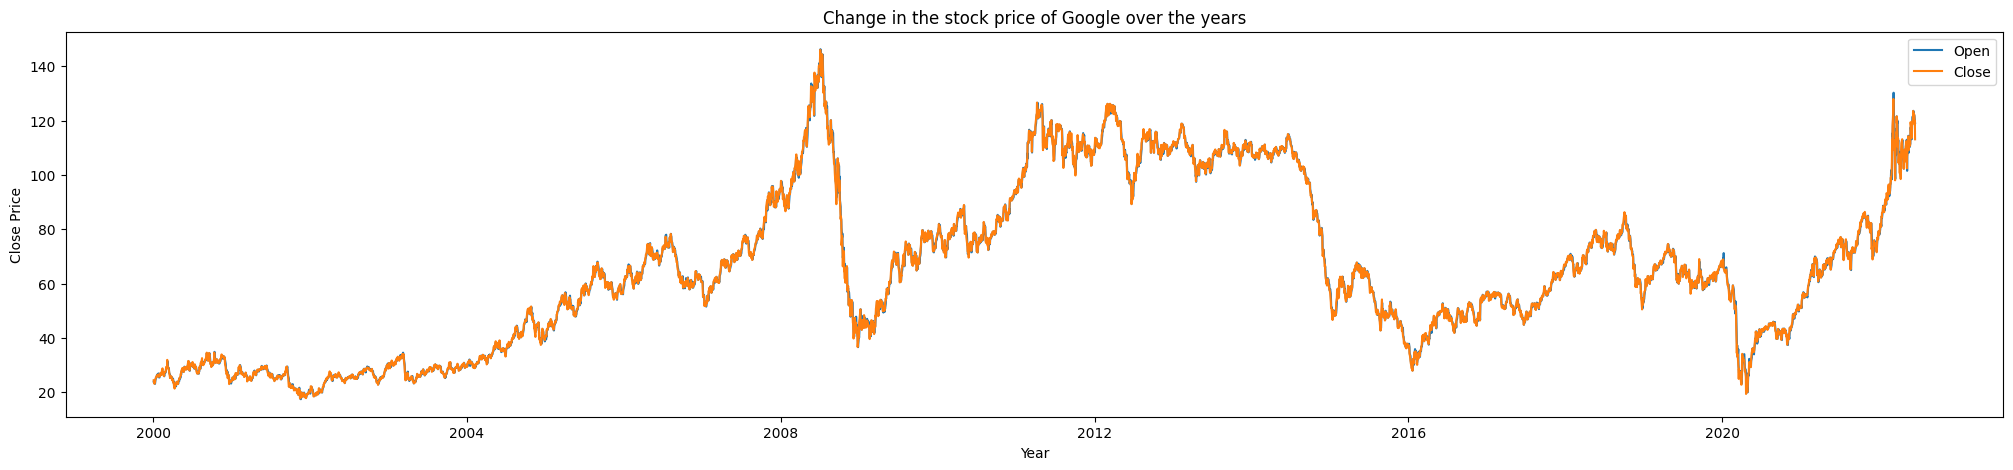

In [12]:
plt.figure(figsize=(25,5))
plt.plot(df1['Date'],df1['Open'], label='Open')
plt.plot(df1['Date'],df1['Close'], label='Close')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend()
plt.title('Change in the stock price of Google over the years')

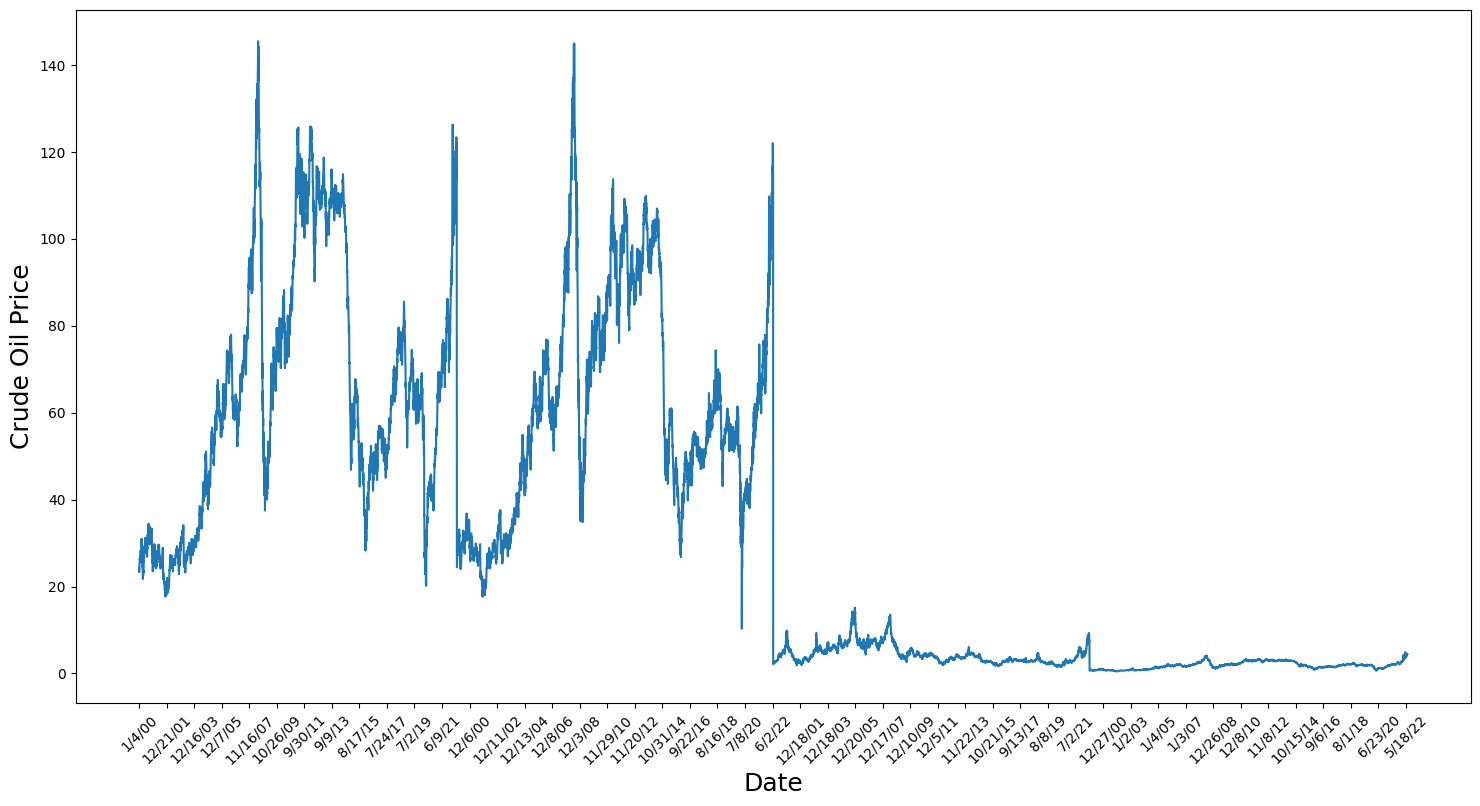

In [127]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Open'] + df['Close'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Crude Oil Price',fontsize=18)
plt.show()

####Changing the ‘Date Starting’ column to a date datatype:

In [69]:
df['Date'] = pd.to_datetime(df['Date'])

In [70]:
df.dtypes

Symbol              object
Date        datetime64[ns]
Open               float64
High               float64
Low                float64
Close              float64
Volume               int64
Currency            object
dtype: object

In [71]:
#Selecting columns of interest
df1 = df.drop(['High','Low', 'Volume', 'Currency', 'Symbol'], axis=1)

In [72]:
df1.dtypes

Date     datetime64[ns]
Open            float64
Close           float64
dtype: object

Now we apply data visualization to enable us to visually examine and comprehend patterns and trends in data, as well as expose linkages, outliers, and potential mistakes.

Text(0.5, 1.0, 'Change in the stock price of Google over the years')

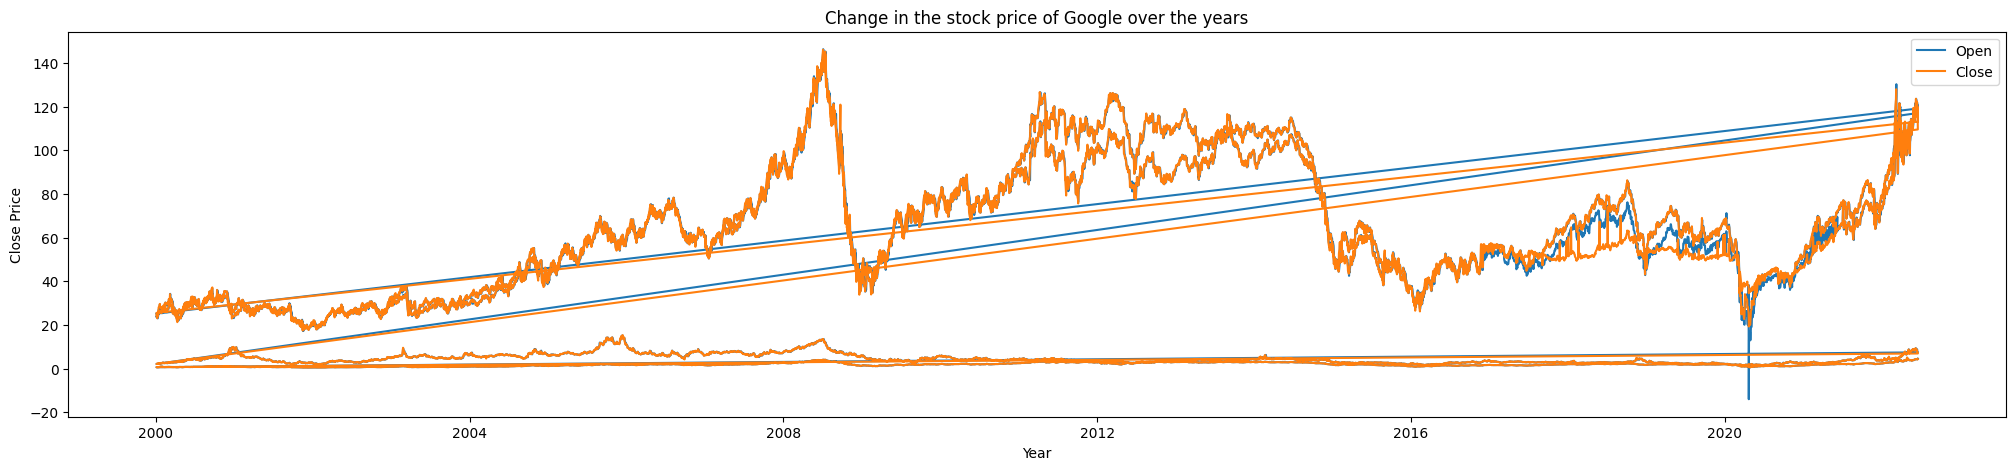

In [73]:
plt.figure(figsize=(25,5))
plt.plot(df1['Date'],df1['Open'], label='Open')
plt.plot(df1['Date'],df1['Close'], label='Close')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend()
plt.title('Change in the stock price of Google over the years')

Text(0.5, 1.0, 'Change in the crude oil price over the years')

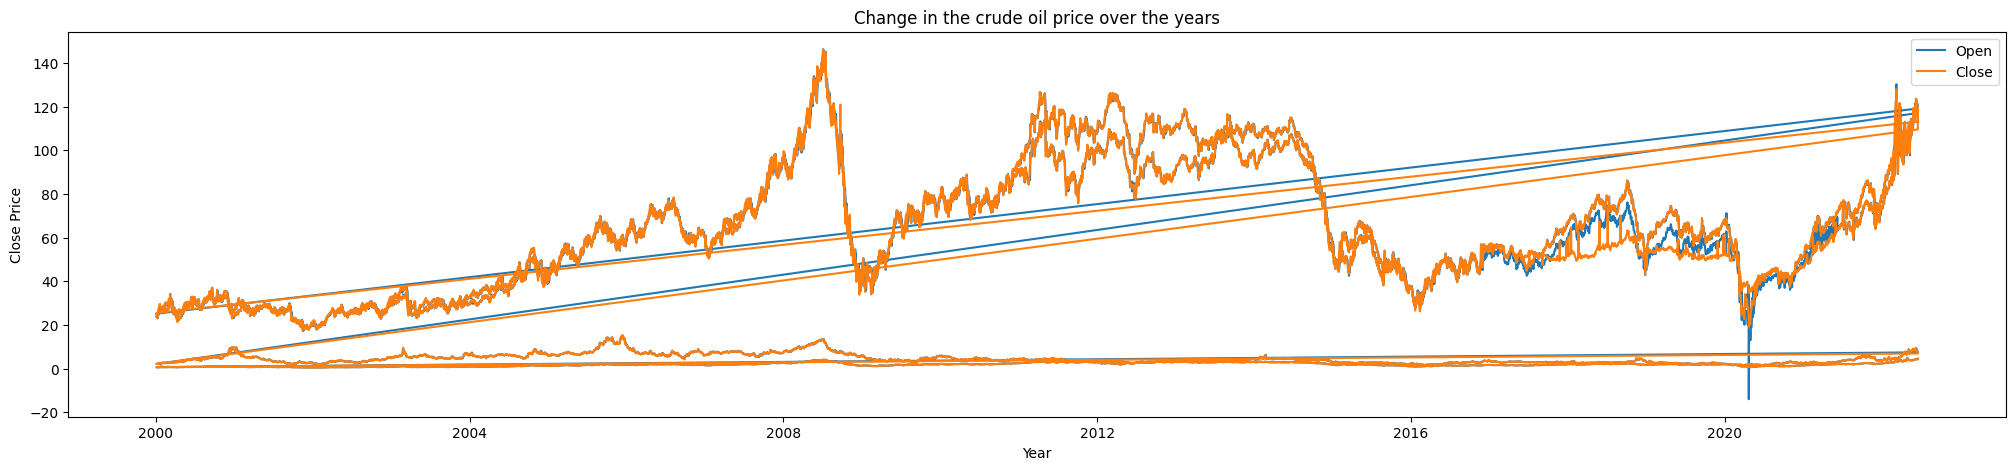

In [58]:
#Change in the crude oil price over the years:
plt.figure(figsize=(25,5))
plt.plot(df1['Date'],df['Open'], label='Open')
plt.plot(df1['Date'],df['Close'], label='Close')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend()
plt.title('Change in the crude oil price over the years')

####Selecting columns of interest

In [59]:
df1 = df[['Date', 'Symbol', 'Close']]
df1.head(5)

,Date,Symbol,Close
0,2000-01-04,Brent Oil,24.39
1,2000-01-05,Brent Oil,23.73
2,2000-01-06,Brent Oil,23.62
3,2000-01-07,Brent Oil,23.09
4,2000-01-10,Brent Oil,23.73


####Visualizing the adjusted close price data

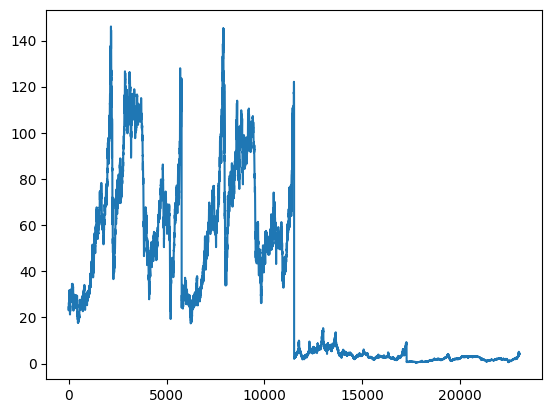

In [ ]:
# Ploting adjusted close price data
df['Close'].plot()
plt.show()

####Improving the legibility of the plot by scaling it, labeling it appropriately, and adding grid lines.

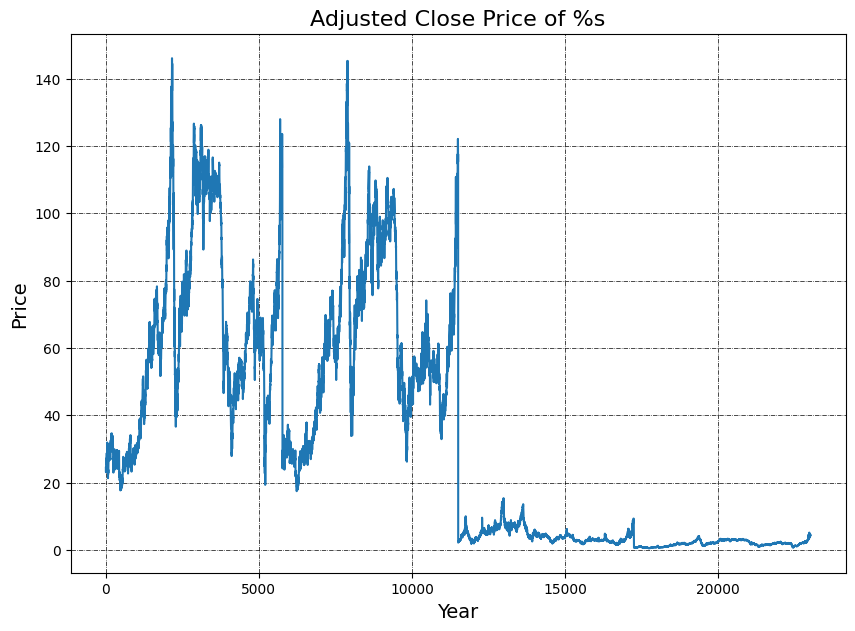

In [ ]:
# Plot the adjusted close price
df['Close'].plot(figsize=(10, 7))

# Define the label for the title of the figure
plt.title("Adjusted Close Price of %s", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

# Show the plot
plt.show()

In [ ]:
df.dtypes

Symbol       object
Date         object
Open        float64
High        float64
Low         float64
Close       float64
Volume        int64
Currency     object
dtype: object